# XAI Analysis Notebook
This notebook focuses exclusively on the eXplainable AI (XAI) portion of the project, corresponding to Sprint 2. We will load the champion model and the dataset to generate and visualize SHAP explanations.

---

## 1. Setup and Library Imports

In [10]:
import pandas as pd
import os
import joblib
import shap
from sklearn.model_selection import train_test_split

print("Libraries imported successfully.")


Libraries imported successfully.


## 2. Load Assets
Load the necessary assets: the test data, the champion model.

Create the SHAP explainer.

In [11]:
# --- Load Test Data ---
# We need the test set to generate explanations for.
try:
    df1 = pd.read_csv('data/phishing_dataset_ml_full.csv')
    if 'id' in df1.columns: df1 = df1.drop('id', axis=1)
    X1 = df1.drop('CLASS_LABEL', axis=1)
    y1 = df1['CLASS_LABEL']
    x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=42)
    print("Test data loaded and prepared successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure it exists in the 'data' directory.")

# --- Load Champion Model ---
try:
    champion_model = joblib.load('models/url_model_ds1.joblib')
    print("Champion model (url_model_ds1.joblib) loaded.")
except FileNotFoundError:
    print("Error: Champion model not found. Please ensure you have run the training notebook first.")

Test data loaded and prepared successfully.
Champion model (url_model_ds1.joblib) loaded.


## 3. Create SHAP Explainer and Calculate Values
The modern SHAP API allows creating an explainer and calculating values in a more streamlined way.
Providing background data (x_train) to the explainer is good practice.
Calling the explainer on the test set returns a rich Explanation object directly.

- **Explainer object**:
  * The explainer object can be indexed in three ways `[<instance_index>, <feature_index>, <target_class>]`.
  * The *instance_index* specifies which instance do you want to explain or how many.
  * The *feature_index* specifies which features you want to include in the model.
  * The *target_class* (*class_specifier* or *result_specifier* for non binary classifications) spacifies what class do you want the calculations to point towards.


In [12]:
# --- Create the explainer ---
# Pass the model and background data to the explainer for better stability
explainer = shap.TreeExplainer(champion_model, x_train)
# Save the explainer
joblib.dump(explainer, 'models/url_explainer.joblib')
print("\nSHAP explainer has been serialized to 'models/url_explainer.joblib'")

# Calculate SHAP values - this now returns a full Explanation object
shap_explanation = explainer(x_test)
print("SHAP values and Explanation object created successfully.")


SHAP explainer has been serialized to 'models/url_explainer.joblib'


100%|===================| 3989/4000 [01:22<00:00]        

SHAP values and Explanation object created successfully.


## 4. Global Feature Importance: Summary Plots
These plots show the overall importance of features. The bar plot gives a simple ranked list, while the beeswarm plot provides more detail on the distribution of each feature's impact.
Note: For binary classification, the new Explanation object contains values for both classes.
We use the slicing syntax [:,:,1] to select the explanations for the "phishing" class (class 1).

### Bar Plot: Global Feature Importance
- This plot provides a high-level overview of the model's behavior. It calculates the average impact of each feature across all the predictions in your test dataset and ranks them from most to least important.
- **How to read it**:
  * The longer the bar, the more influence that feature has on the model's predictions, on average.
  * This plot answers the question: "Overall, what are the most important factors the model uses to distinguish between phishing and legitimate URLs?"
  * For AegisLens, this helps us confirm that the model is focusing on sensible, expected features (like hyperlink percentages, URL length, etc.) rather than irrelevant noise.


--- Generating SHAP Bar Plot (Global Feature Importance) ---


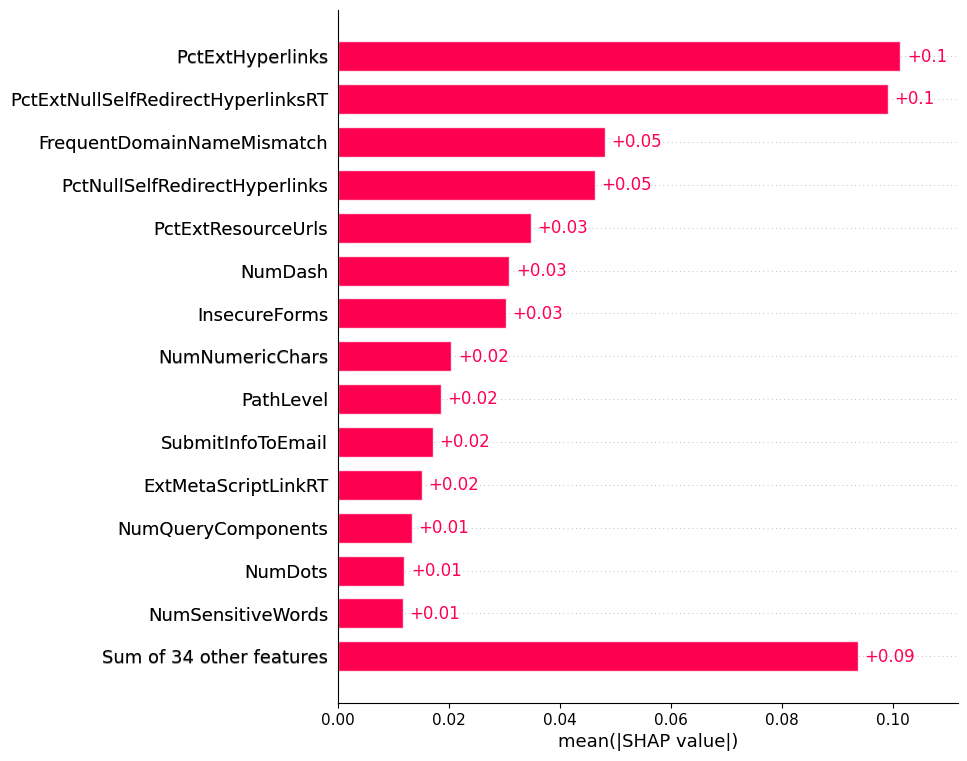

In [13]:
print("\n--- Generating SHAP Bar Plot (Global Feature Importance) ---")
shap.plots.bar(shap_explanation[:,:,1], max_display=15)

### Beeswarm Plot
- The beeswarm plot is a more detailed version of the bar plot. Instead of just an average, it shows the impact of each feature for every single prediction in the test set.
- **How to read it**:
  * Each dot represents a single URL.
  * The **horizontal position** of the dot shows its SHAP value—how much it pushed the prediction for that specific URL. Values > 0 push towards "phishing" (class 1), and values < 0 push towards "legitimate" (class 0).
  * The **color** of the dot indicates the feature's value for that URL (e.g., red for high values, blue for low values).
  * **Example Interpretation**: You might see that for the feature PctExtHyperlinks, the red dots (high percentage of external links) are all on the positive side of the SHAP value axis. This tells you that a high value for this feature consistently pushes the model to predict "phishing."


--- Generating SHAP Beeswarm Plot (Detailed Global Importance) ---


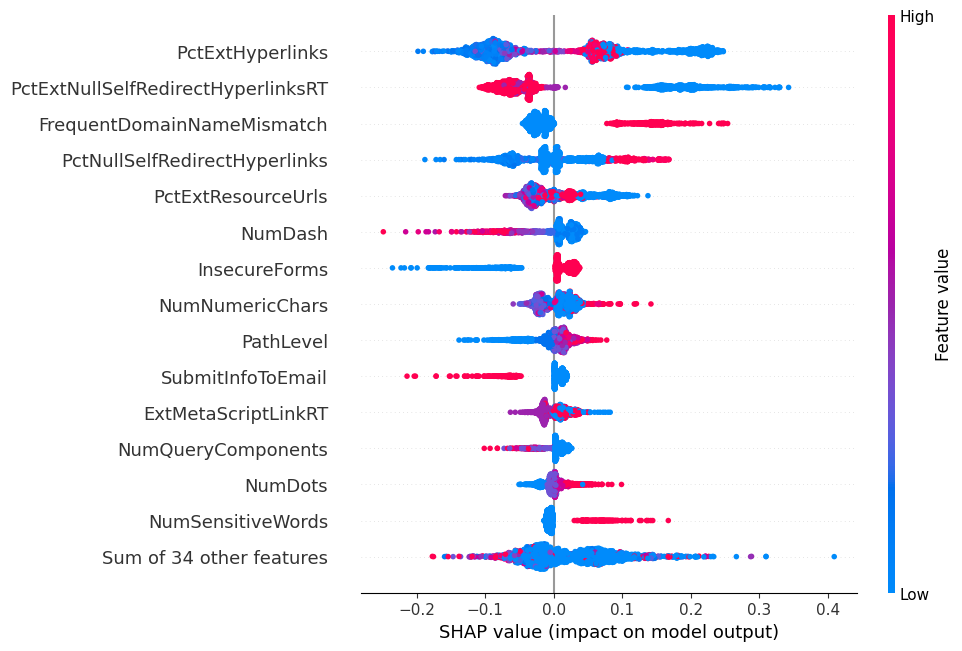

In [14]:
print("\n--- Generating SHAP Beeswarm Plot (Detailed Global Importance) ---")
shap.plots.beeswarm(shap_explanation[:,:,1], max_display=15)

## 5. Local Prediction Explanation: Waterfall Plot
This plot shows how the individual features of a single URL contributed to its final prediction score.
We'll examine the first phishing instance and the first legitimate instance from our test set.

- This is the most crucial plot for explaining a single prediction to an end-user. It shows exactly how the model arrived at its decision for one specific URL by starting at a base value and adding or subtracting the contribution of each feature.
- **How to read it**:
  * **E[f(x)]**: The starting point at the bottom is the "base value," which is the average prediction of the model over the entire dataset for the specified class.
  * **Arrows**: Red arrows show features that pushed the prediction higher (towards the specified class in [loc, :, **x**] where *x = 1* is phishing and *x = 0* is legitimate). Blue arrows show features that pushed it lower from being the class. The length of the arrow indicates the magnitude of its contribution.
  * **f(x)**: The final value at the top is the model's output score for that specific instance. In other words, the likelihood of the specified instance being considered the specified class.


In [42]:
# Find the index of the first phishing example in the test set
first_phishing_index = y_test[y_test == 1].index[0]
loc_phishing = x_test.index.get_loc(first_phishing_index)

# Find the index of the first legitimate example in the test set
first_legit_index = y_test[y_test == 0].index[0]
loc_legit = x_test.index.get_loc(first_legit_index)

print(f"\nExplaining phishing prediction for instance at index: {first_phishing_index}")
print(f"Explaining legitimate prediction for instance at index: {first_legit_index}")


Explaining phishing prediction for instance at index: 911
Explaining legitimate prediction for instance at index: 7919


### Explanation for a Phishing URL
We again slice with [loc_phishing, :, 1] to get the explanation for the specific instance and for class 1.


--- Waterfall plot for a phishing URL ---


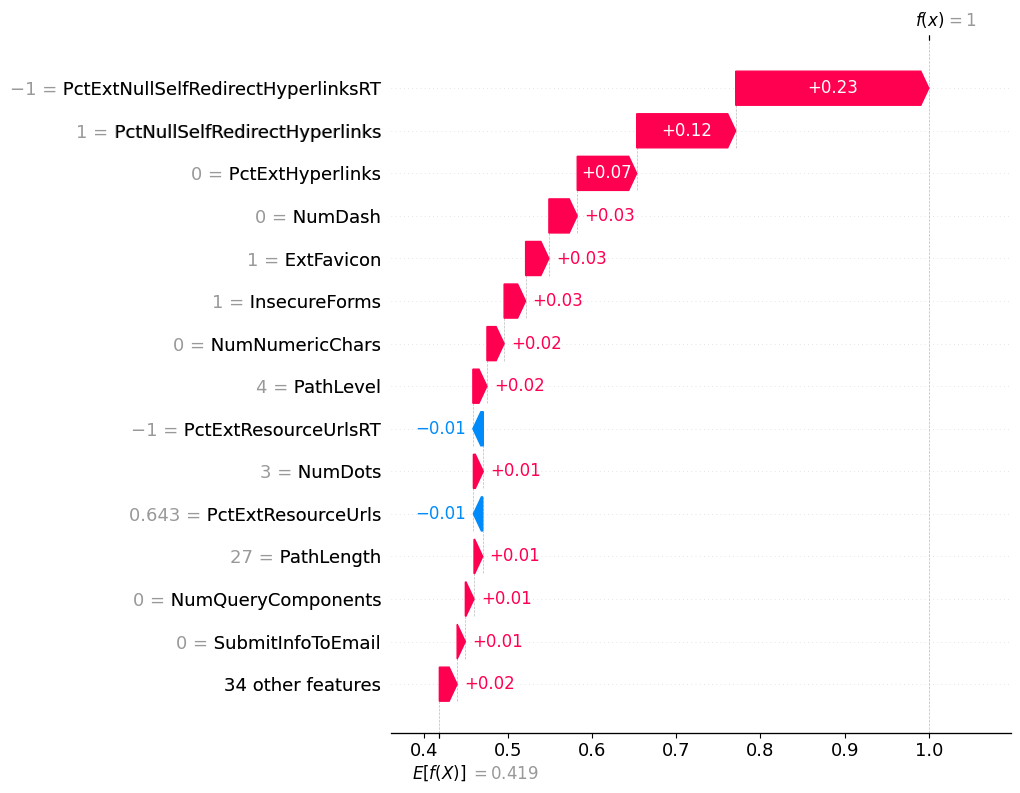

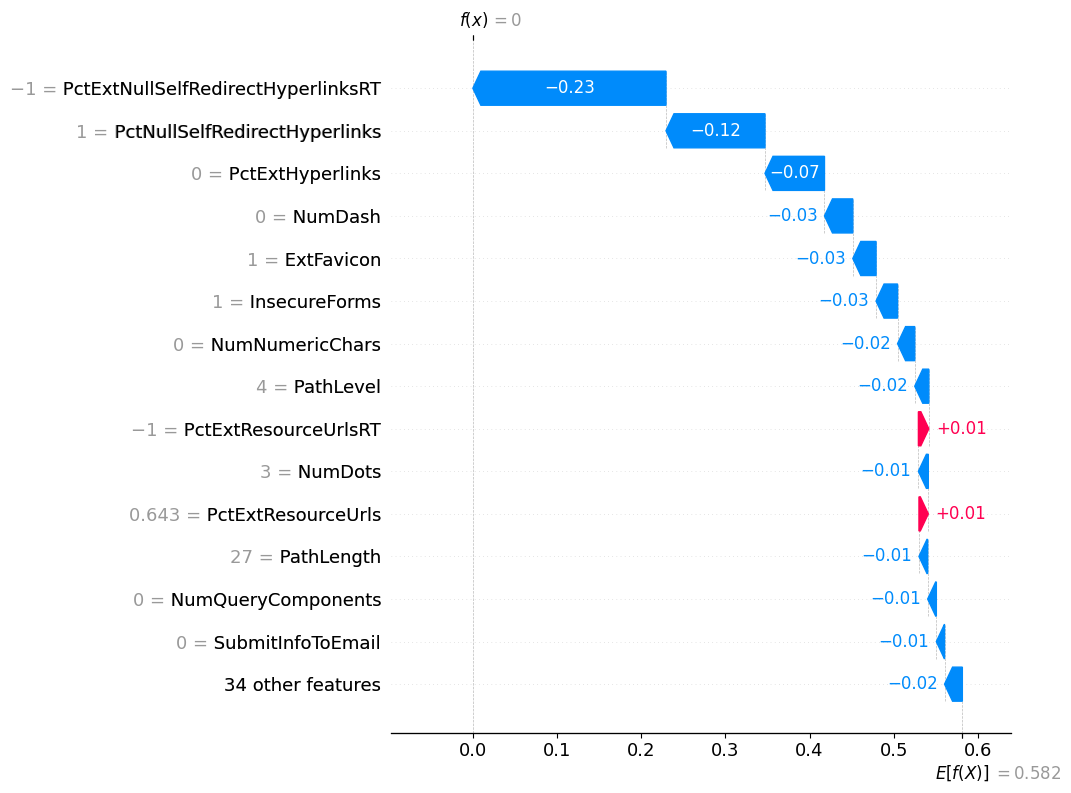

In [65]:
print("\n--- Waterfall plot for a phishing URL ---")
# Likelihood of it being phishing
shap.plots.waterfall(shap_explanation[loc_phishing, :, 1], max_display=15)
# Likelihood of it being legitimate
shap.plots.waterfall(shap_explanation[loc_phishing, :, 0], max_display=15)

### Explanation for a Legitimate URL
Here we slice for class 0 (legitimate) to see the features pushing the prediction *away* from phishing.

- **Selected code** `shap.plots.waterfall(shap_explanation[loc_legit, :, 0], ...)`:
  * This is a particularly insightful plot. By using `[:, :, 0]`, you are asking SHAP to explain the prediction for class 0 (legitimate).
  * The resulting waterfall plot will show the features that are contributing to the URL being classified as **safe**. You'll likely see features with *red* arrows (when specifying class 0), pushing the final score *up* from the base value, reinforcing the model's confidence that the URL is not a phishing attempt (the inverse is seen when specifying class 1). This is fundamental to building user trust—not just showing why something is dangerous, but also why something is safe.


--- Waterfall plot for a legitimate URL (explaining class 0) ---


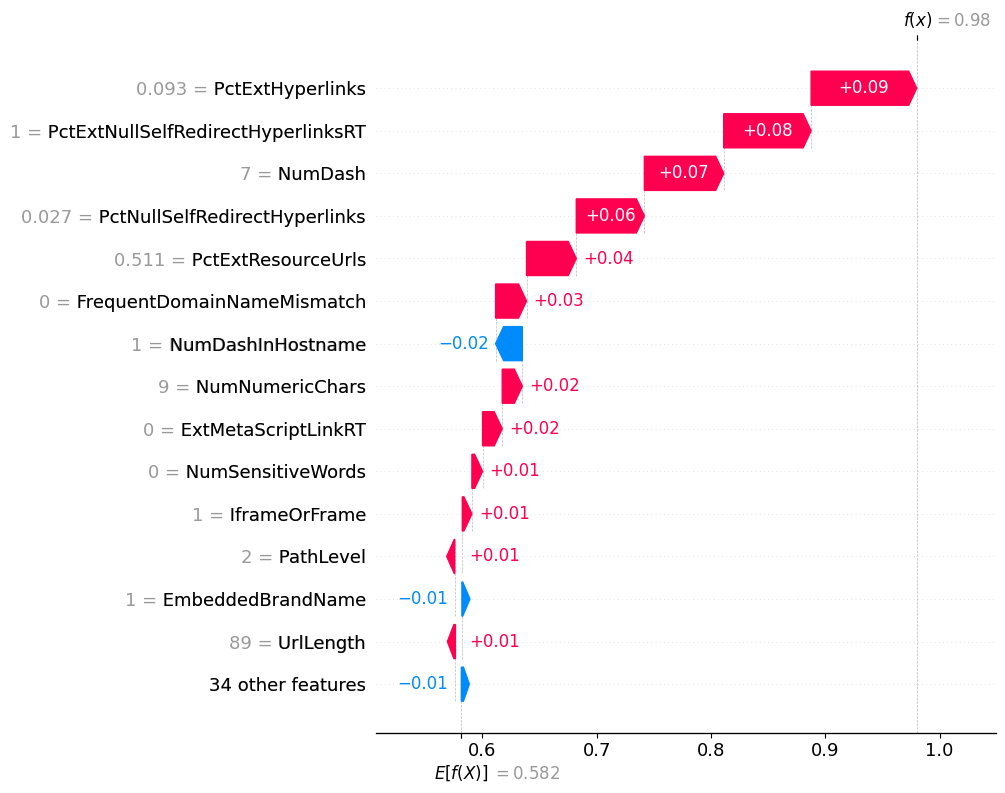

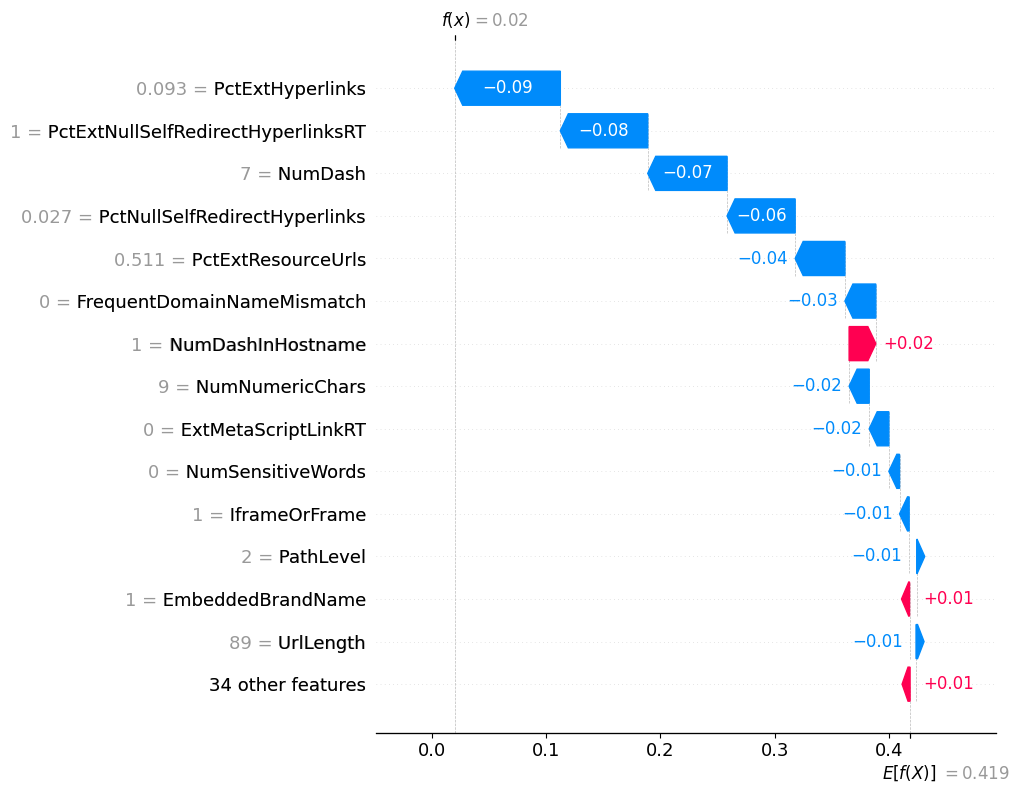

In [66]:
print("\n--- Waterfall plot for a legitimate URL (explaining class 0) ---")
# Likelihood of instance being legitimate
shap.plots.waterfall(shap_explanation[loc_legit, :, 0], max_display=15)
# Likelihood of instance being phishing
shap.plots.waterfall(shap_explanation[loc_legit, :, 1], max_display=15)